### $\text{\underline{Libraries and Global Constants}}$

In [67]:
import numpy as np
import torch as t
import matplotlib.pyplot as plt
device = t.device("cpu")
num_x = 36
acc_list = []
font = {'fontname':'AppleGothic'}

### $\underline{\text{Dataset Storage Class}}$

In [68]:
class Dataset(t.utils.data.Dataset):

    def __init__(self,src_file,num_rows,skip):
        # Load data
        x_temp = np.loadtxt(src_file,max_rows=num_rows,skiprows=skip,usecols=range(0,num_x),delimiter=',',dtype=np.float32)
        y_storage = np.loadtxt(src_file,max_rows=num_rows,skiprows=skip,usecols=num_x,delimiter=',',dtype=str)
        y_temp = np.zeros_like(y_storage,dtype=np.float32)
        # Convert string attribute to numerical value
        y_temp[y_storage == r"'Anomaly'"] = 1
        self.x_data = t.tensor(x_temp).to(device)
        self.x_data = self.x_data.float()
        self.y_data = t.tensor(y_temp).to(device)
        self.y_data = self.y_data.long()
        # Shuffle the tensors
        self.x_data = self.x_data[t.randperm(self.x_data.size()[0])]
        self.y_data = self.y_data[t.randperm(self.y_data.size()[0])]

    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self,index):
        if t.is_tensor(index):
            index = index.tolist()
        preds = self.x_data[index,0:num_x]
        result = self.y_data[index]
        sample = {'Predictors':preds,'Anomalous':result}
        return sample


### $ \underline{\text{The Model}}$

In [72]:
# Create training dataset instance, skips the first 39 rows as they are not part of the dataset
train_ds = Dataset("data.txt",num_rows=4897,skip=39)
# Define sequential model architecture
model = t.nn.Sequential(
    t.nn.Linear(36,26),        # 26 hidden neurons
    t.nn.ReLU(),
    t.nn.Linear(26,2)
)
# Define loss function
loss_func = t.nn.CrossEntropyLoss()
# Define optimizer
optimizer = t.optim.Adam(model.parameters(),lr=0.01,weight_decay=1e-6)
# Training model
print("Training the model")
for epoch in range(1000):
    # Feed the model the dataset
    mod_output = model(train_ds.x_data)
    # Obtain a tensor (maxes) with only the most likely classificiations
    maxes = mod_output.max(dim=1)[1]
    # Use maxes tensor to count number of equal values between our model output and the target tensor
    acc = t.sum((maxes==train_ds.y_data))/len(train_ds.y_data)
    # Store accuracy over all epochs for plotting
    acc_list.append(acc.item())
    # Calculate the loss
    loss = loss_func(mod_output,train_ds.y_data)
    if epoch % 100 == 99:
        print("Epoch: ",epoch," Loss: ",loss.item()," Accuracy: ",acc.item())
    # Sets the gradients of all optimized tensors s to zero
    optimizer.zero_grad()
    # Computes the gradient of current tensor w.r.t. graph leaves
    loss.backward()
    # Performs a single optimization step
    optimizer.step()
print("Testing the model")
# Create instance for testing data and then performs similar procedure as above
test_ds = Dataset("test_data.txt",num_rows=220,skip=0)
test_pred = model(test_ds.x_data)
maxos = test_pred.max(dim=1)[1]
acc_tst = t.sum((maxos==test_ds.y_data))/len(test_ds.y_data)
print("Loss:",loss_func(test_pred,test_ds.y_data).item(),"Accuracy:",acc_tst.item())


Training the model
Epoch:  99  Loss:  0.4053235352039337  Accuracy:  0.9868258833885193
Epoch:  199  Loss:  0.08155082911252975  Accuracy:  0.98517906665802
Epoch:  299  Loss:  0.07463785260915756  Accuracy:  0.9868258833885193
Epoch:  399  Loss:  0.0723273828625679  Accuracy:  0.9868258833885193
Epoch:  499  Loss:  0.07152177393436432  Accuracy:  0.9868258833885193
Epoch:  599  Loss:  0.07110683619976044  Accuracy:  0.9868258833885193
Epoch:  699  Loss:  0.07082241028547287  Accuracy:  0.9868258833885193
Epoch:  799  Loss:  0.07059502601623535  Accuracy:  0.9868258833885193
Epoch:  899  Loss:  0.07039997726678848  Accuracy:  0.9868258833885193
Epoch:  999  Loss:  0.07022737711668015  Accuracy:  0.9868258833885193
Testing the model
Loss: 0.22233547270298004 Accuracy: 0.949999988079071


### $\underline{\text{Plotting}} $

In [73]:
# Plot accuracy error for a single model, input is the model's accuracy 
def plot_acc_error(acc_arr,title):
    length = len(acc_arr)
    fig,ax = plt.subplots(figsize=(7,7))
    ax.plot(np.array(range(0,length)),1-np.array(acc_arr),color='darkorange',linewidth=0.6)
        
    ax.set_title(title,**font,color='aliceblue')
    ax.set_ylabel("Percentage error",**font,color='aliceblue')
    ax.set_xlabel('Epochs',**font,color='aliceblue')

    ax.set_yscale("log")
    ax.set_facecolor('dimgray')
    fig.set_facecolor('dimgray')

    ax.tick_params(axis='y', colors='aliceblue')
    ax.tick_params(axis='x', colors='aliceblue')
    ax.spines['bottom'].set_color('aliceblue')
    ax.spines['left'].set_color('aliceblue')
    ax.spines['top'].set_color('dimgray')
    ax.spines['right'].set_color('dimgray')

    plt.show()

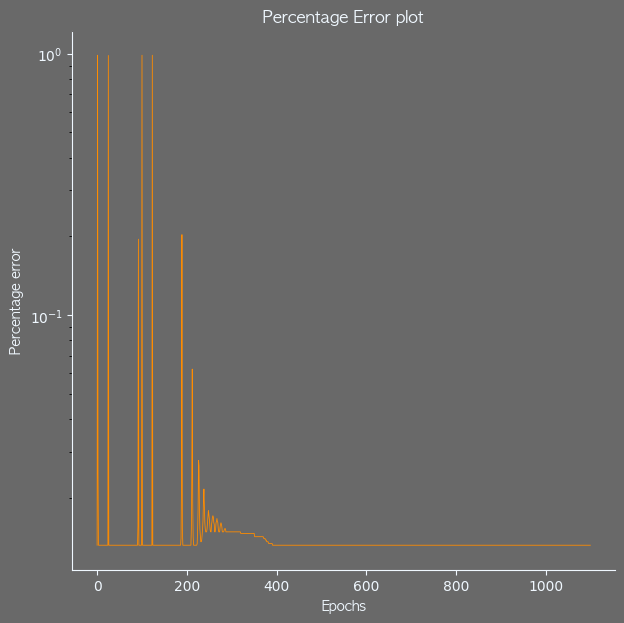

In [74]:
plot_acc_error(np.array(acc_list),"Percentage Error plot")